# Matter-Antimatter asymmetries at the LHC

### Overview
This notebook contains an example analysis of LHCb open data from the University of Manchester undergraduate laboratory project on matter-antimatter asymmetries. Here we demonstrate an alternative implementation of the solution rewritten with ROOT.

In [1]:
import time
start_time = time.time()

import datetime
now = datetime.datetime.now()
print(f"Starting execution at: {now.hour}:{now.minute}")

Starting execution at: 17:10


### Configuration
The cell below imports all required Python modules.

In [2]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep  


# Constants
mpi = 140.
mK = 494.
mD = 1865.
mJp = 3097.
mp2S = 3686.
mB = 5280.
probK_all = 0.5
probK_high = 0.8
probK_sum = 2.1
probK_max = 0.7
probpi_all = 0.6
probpi_sum2 = 1.3
probpi_sum = 2.4
mass_cut = 50.
mass_cut_D = 20.

print('Done!')

Done!


### Input data
Creates a ROOT RDataFrame using the input data files we have.

In [3]:
# Enable RDataFrame implicit multi-threading
ROOT.EnableImplicitMT()

# Create a chain combining the files needed for the analysis
tree_name = "DecayTree"
input_files = [
    "../data/B2HHH_MagnetDown.root",
    "../data/B2HHH_MagnetUp.root",
]

chain = ROOT.TChain(tree_name)
for f in input_files:
    chain.Add(f)

# Load the combined data using RDataFrame
df = ROOT.RDataFrame(chain)

# Check what's in the tree. 
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(df.GetColumnNames())

Input data variables:
{ "B_FlightDistance", "B_VertexChi2", "H1_Charge", "H1_IPChi2", "H1_PX", "H1_PY", "H1_PZ", "H1_ProbK", "H1_ProbPi", "H1_isMuon", "H2_Charge", "H2_IPChi2", "H2_PX", "H2_PY", "H2_PZ", "H2_ProbK", "H2_ProbPi", "H2_isMuon", "H3_Charge", "H3_IPChi2", "H3_PX", "H3_PY", "H3_PZ", "H3_ProbK", "H3_ProbPi", "H3_isMuon" }


### Select data and calculate derived quantities
The following cells reads the input data. This is where all derived quantities (such as transverse momentum) should are calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [4]:
# Calculate derived quantities
df = (
    df.Define("pT_H1", "sqrt(H1_PX*H1_PX + H1_PY*H1_PY)")
       .Define("pT_H2", "sqrt(H2_PX*H2_PX + H2_PY*H2_PY)")
       .Define("pT_H3", "sqrt(H3_PX*H3_PX + H3_PY*H3_PY)")
)

df = (
    df.Define("e_pi1", f"sqrt(H1_PX*H1_PX + H1_PY*H1_PY + H1_PZ*H1_PZ + {mpi*mpi})")
       .Define("e_pi2", f"sqrt(H2_PX*H2_PX + H2_PY*H2_PY + H2_PZ*H2_PZ + {mpi*mpi})")
       .Define("e_pi3", f"sqrt(H3_PX*H3_PX + H3_PY*H3_PY + H3_PZ*H3_PZ + {mpi*mpi})")
)

df = (
    df.Define("e_K1", f"sqrt(H1_PX*H1_PX + H1_PY*H1_PY + H1_PZ*H1_PZ + {mK*mK})")
       .Define("e_K2", f"sqrt(H2_PX*H2_PX + H2_PY*H2_PY + H2_PZ*H2_PZ + {mK*mK})")
       .Define("e_K3", f"sqrt(H3_PX*H3_PX + H3_PY*H3_PY + H3_PZ*H3_PZ + {mK*mK})")
)

df = (
    df.Define("p12sq", "(H1_PX + H2_PX)*(H1_PX + H2_PX) + (H1_PY + H2_PY)*(H1_PY + H2_PY) + (H1_PZ + H2_PZ)*(H1_PZ + H2_PZ)")
      .Define("p23sq", "(H2_PX + H3_PX)*(H2_PX + H3_PX) + (H2_PY + H3_PY)*(H2_PY + H3_PY) + (H2_PZ + H3_PZ)*(H2_PZ + H3_PZ)")
      .Define("p13sq", "(H1_PX + H3_PX)*(H1_PX + H3_PX) + (H1_PY + H3_PY)*(H1_PY + H3_PY) + (H1_PZ + H3_PZ)*(H1_PZ + H3_PZ)")
      .Define("psq", "(H1_PX + H2_PX + H3_PX)*(H1_PX + H2_PX + H3_PX) + "
                     "(H1_PY + H2_PY + H3_PY)*(H1_PY + H2_PY + H3_PY) + "
                     "(H1_PZ + H2_PZ + H3_PZ)*(H1_PZ + H2_PZ + H3_PZ)")
)

df = (
    # KK
    df.Define("m12KKsq", "(e_K1 + e_K2)*(e_K1 + e_K2) - p12sq")
      .Define("m23KKsq", "(e_K2 + e_K3)*(e_K2 + e_K3) - p23sq")
      .Define("m13KKsq", "(e_K1 + e_K3)*(e_K1 + e_K3) - p13sq")
    # pipi
      .Define("m12pipisq", "(e_pi1 + e_pi2)*(e_pi1 + e_pi2) - p12sq")
      .Define("m23pipisq", "(e_pi2 + e_pi3)*(e_pi2 + e_pi3) - p23sq")
      .Define("m13pipisq", "(e_pi1 + e_pi3)*(e_pi1 + e_pi3) - p13sq")
    # Kpi/ piK
      .Define("m12Kpisq", "(e_K1 + e_pi2)*(e_K1 + e_pi2) - p12sq")
      .Define("m23Kpisq", "(e_K3 + e_pi2)*(e_K3 + e_pi2) - p23sq")
      .Define("m13Kpisq", "(e_K1 + e_pi3)*(e_K1 + e_pi3) - p13sq")
      .Define("m12piKsq", "(e_pi1 + e_K2)*(e_pi1 + e_K2) - p12sq")
      .Define("m23piKsq", "(e_pi3 + e_K2)*(e_pi3 + e_K2) - p23sq")
      .Define("m13piKsq", "(e_pi1 + e_K3)*(e_pi1 + e_K3) - p13sq")
)

df = (
    df.Define("mKKKinv", "sqrt((e_K1 + e_K2 + e_K3)*(e_K1 + e_K2 + e_K3) - psq)")
      .Define("mpipipiinv", "sqrt((e_pi1 + e_pi2 + e_pi3)*(e_pi1 + e_pi2 + e_pi3) - psq)")
      .Define("mKpipiinv", "sqrt((e_K1 + e_pi2 + e_pi3)*(e_K1 + e_pi2 + e_pi3) - psq)")
      .Define("mpiKpiinv", "sqrt((e_pi1 + e_K2 + e_pi3)*(e_pi1 + e_K2 + e_pi3) - psq)")
      .Define("mpipiKinv", "sqrt((e_pi1 + e_pi2 + e_K3)*(e_pi1 + e_pi2 + e_K3) - psq)")
)

print(f'Read {df.Count().GetValue()} events.')

Read 8556118 events.


In [5]:
# Decide here which events to analyse
df_basic = (
    df.Filter("H1_PZ > 0 && H2_PZ > 0 && H3_PZ > 0", "Positive PZ")
    .Filter("!H1_isMuon && !H2_isMuon && !H3_isMuon", "Not muons")
)

In [6]:
# KKK Helpers
df_basic = df_basic.Define("KK_low_sq", """
    double result = -999.0;
    if (H1_Charge == H2_Charge) {
        result = (m13KKsq > m23KKsq) ? m23KKsq : m13KKsq;
    } else if (H1_Charge == H3_Charge) {
        result = (m12KKsq > m23KKsq) ? m23KKsq : m12KKsq;
    } else if (H2_Charge == H3_Charge) {
        result = (m12KKsq > m13KKsq) ? m13KKsq : m12KKsq;
    }
    return result;
""")

df_basic = df_basic.Define("KK_high_sq", """
    double result = -999.0;
    if (H1_Charge == H2_Charge) {
        result = (m13KKsq > m23KKsq) ? m13KKsq : m23KKsq;
    } else if (H1_Charge == H3_Charge) {
        result = (m12KKsq > m23KKsq) ? m12KKsq : m23KKsq;
    } else if (H2_Charge == H3_Charge) {
        result = (m12KKsq > m13KKsq) ? m12KKsq : m13KKsq;
    }
    return result;
""")

df_basic = df_basic.Define("is_KKK_candidate", f"""
    return (H1_ProbK > {probK_all} &&
            H2_ProbK > {probK_all} &&
            H3_ProbK > {probK_all} &&
            (H1_ProbK + H2_ProbK + H3_ProbK) > {probK_sum});
""")

df_basic = df_basic.Define(
    "KKK_in_B_window",
    f"abs(mKKKinv - {mB}) < {mass_cut}"
)

df_basic = df_basic.Define("KKK_pass_D_veto", f"""
    return (KK_low_sq > 0 &&
            abs(sqrt(KK_low_sq) - {mD}) > {mass_cut_D});
""")

In [7]:
# KKK selection
df_basic = df_basic.Define("m_KKK", """
    return (is_KKK_candidate && KKK_pass_D_veto) ? mKKKinv : -999.0;
""")

df_basic = df_basic.Define("mKKlow", """
    return (is_KKK_candidate && KKK_in_B_window) ? KK_low_sq : -999.0;
""")

df_basic = df_basic.Define("mKKhigh", """
    return (is_KKK_candidate && KKK_in_B_window) ? KK_high_sq : -999.0;
""")

In [8]:
# KKK df
df_kkk = df_basic.Filter(
    "is_KKK_candidate",
    "KKK candidates"
)

df_kkk_mass_window = df_kkk.Filter(
    "KKK_in_B_window",
    "KKK in B mass window"
)

df_kkk_selected = df_kkk.Filter(
    "m_KKK > 0",
    "KKK selected (valid mass)"
)

In [9]:
# KKK counters
kkk_candidates  = df_kkk.Count()
kkk_mass_window = df_kkk_mass_window.Count()
kkk_selected    = df_kkk_selected.Count()

In [10]:
# πππ Helpers
df_basic = df_basic.Define("PIPIPI_low_sq", """
    double result = -999.0;
    if (H1_Charge == H2_Charge) {
        result = std::min(m13pipisq, m23pipisq);
    } else if (H1_Charge == H3_Charge) {
        result = std::min(m12pipisq, m23pipisq);
    } else if (H2_Charge == H3_Charge) {
        result = std::min(m12pipisq, m13pipisq);
    }
    return result;
""")

df_basic = df_basic.Define("PIPIPI_high_sq", """
    double result = -999.0;
    if (H1_Charge == H2_Charge) {
        result = std::max(m13pipisq, m23pipisq);
    } else if (H1_Charge == H3_Charge) {
        result = std::max(m12pipisq, m23pipisq);
    } else if (H2_Charge == H3_Charge) {
        result = std::max(m12pipisq, m13pipisq);
    }
    return result;
""")

df_basic = df_basic.Define("is_PIPIPI_candidate", f"""
    return (H1_ProbPi > {probpi_all} &&
            H2_ProbPi > {probpi_all} &&
            H3_ProbPi > {probpi_all} &&
            H1_ProbK < {probK_max} &&
            H2_ProbK < {probK_max} &&
            H3_ProbK < {probK_max} &&
            (H1_ProbPi + H2_ProbPi + H3_ProbPi) > {probpi_sum});
""")

df_basic = df_basic.Define(
    "PIPIPI_in_B_window",
    f"abs(mpipipiinv - {mB}) < {mass_cut}"
)

df_basic = df_basic.Define("PIPIPI_pass_D_veto", f"""
    return (PIPIPI_low_sq > 0 &&
            abs(sqrt(PIPIPI_low_sq) - {mD}) > {mass_cut_D} &&
            abs(sqrt(PIPIPI_high_sq) - {mD}) > {mass_cut_D});
""")

In [11]:
# πππ selection
df_basic = df_basic.Define("m_pipipi", """
    return (is_PIPIPI_candidate && PIPIPI_pass_D_veto) ? mpipipiinv : -999.0;
""")

df_basic = df_basic.Define("mpipilow", """
    return (is_PIPIPI_candidate && PIPIPI_in_B_window) ? PIPIPI_low_sq : -999.0;
""")

df_basic = df_basic.Define("mpipihigh", """
    return (is_PIPIPI_candidate && PIPIPI_in_B_window) ? PIPIPI_high_sq : -999.0;
""")

In [12]:
# πππ df
df_pipipi = df_basic.Filter(
    "is_PIPIPI_candidate",
    "PIPIPI_candidates"
)

df_pipipi_mass_window = df_pipipi.Filter(
    "PIPIPI_in_B_window",
    "PIPIPI_mass_window"
)

df_pipipi_selected = df_pipipi.Filter(
    "m_pipipi > 0",
    "PIPIPI_selected"
)

In [13]:
# πππ counters
pipipi_candidates   = df_pipipi.Count()
pipipi_mass_window  = df_pipipi_mass_window.Count()
pipipi_selected     = df_pipipi_selected.Count()

In [14]:
# Kππ Helpers
df_basic = df_basic.Define("kpi_identification", f"""
    int result = 0;
    double max_probK = std::max({{H1_ProbK, H2_ProbK, H3_ProbK}});

    if (H1_ProbK == max_probK && H1_ProbK > {probK_high} &&
        H2_Charge != H3_Charge &&
        H2_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
        (H2_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        result = 1;
    }}
    else if (H2_ProbK == max_probK && H2_ProbK > {probK_high} &&
             H1_Charge != H3_Charge &&
             H1_ProbPi > {probpi_all} && H3_ProbPi > {probpi_all} &&
             (H1_ProbPi + H3_ProbPi) > {probpi_sum2}) {{
        result = 2;
    }}
    else if (H3_ProbK == max_probK && H3_ProbK > {probK_high} &&
             H1_Charge != H2_Charge &&
             H1_ProbPi > {probpi_all} && H2_ProbPi > {probpi_all} &&
             (H1_ProbPi + H2_ProbPi) > {probpi_sum2}) {{
        result = 3;
    }}

    return result;
""")


In [15]:
# Kππ selection
df_basic = df_basic.Define("mKpipi", """
    double result = -999.0;
    if (kpi_identification == 1) result = mKpipiinv;
    else if (kpi_identification == 2) result = mpiKpiinv;
    else if (kpi_identification == 3) result = mpipiKinv;
    return result;
""")

df_basic = df_basic.Define("Kpipi_pass_D_veto", f"""
    bool pass = false;

    if (kpi_identification == 1) {{
        pass = (H1_Charge != H2_Charge)
            ? abs(m12Kpisq - {mD}) > {mass_cut_D}
            : abs(m13Kpisq - {mD}) > {mass_cut_D};
    }}
    else if (kpi_identification == 2) {{
        pass = (H2_Charge != H1_Charge)
            ? abs(m12piKsq - {mD}) > {mass_cut_D}
            : abs(m23Kpisq - {mD}) > {mass_cut_D};
    }}
    else if (kpi_identification == 3) {{
        pass = (H3_Charge != H1_Charge)
            ? abs(m13piKsq - {mD}) > {mass_cut_D}
            : abs(m23piKsq - {mD}) > {mass_cut_D};
    }}

    return pass;
""")

df_basic = df_basic.Define("Kpipi_in_B_window", f"""
    abs(mKpipi - {mB}) < {mass_cut}
""")

df_basic = df_basic.Define("Kpipi_valid_mass", """
    (kpi_identification > 0 && Kpipi_pass_D_veto) ? mKpipi : -999.0
""")

df_basic = df_basic.Define("mpipi", """
    double result = -999.0;
    if (Kpipi_valid_mass > 0) {
        if (kpi_identification == 1) result = m23pipisq;
        else if (kpi_identification == 2) result = m13pipisq;
        else if (kpi_identification == 3) result = m12pipisq;
    }
    return result;
""")

df_basic = df_basic.Define("mKpi", """
    double result = -999.0;
    if (Kpipi_valid_mass > 0) {
        if (kpi_identification == 1) result = m12Kpisq;
        else if (kpi_identification == 2) result = m12piKsq;
        else if (kpi_identification == 3) result = m13piKsq;
    }
    return result;
""")

In [16]:
# Kππ df
df_kpi = df_basic.Filter(
    "kpi_identification > 0",
    "Kππ candidates"
)

df_kpi_mass_window = df_kpi.Filter(
    "Kpipi_in_B_window",
    "Kππ in B mass window"
)

df_kpi_selected = df_kpi.Filter(
    "Kpipi_valid_mass > 0",
    "Kππ selected"
)

In [17]:
# Kππ counters
kpi_candidates   = df_kpi.Count()
kpi_mass_window  = df_kpi_mass_window.Count()
kpi_selected     = df_kpi_selected.Count()

### Visualise data
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

In [18]:
df_kkk_mass_window = df_kkk_mass_window.Define("KKK_mlow_sqrt", "mKKlow > 0 ? sqrt(mKKlow) : -999.0")
df_kkk_mass_window = df_kkk_mass_window.Define("KKK_mhigh_sqrt", "mKKhigh > 0 ? sqrt(mKKhigh) : -999.0")
df_pipipi_mass_window = df_pipipi_mass_window.Define("PIPIPI_mlow_sqrt", "mpipilow > 0 ? sqrt(mpipilow) : -999.0")
df_pipipi_mass_window = df_pipipi_mass_window.Define("PIPIPI_mhigh_sqrt", "mpipihigh > 0 ? sqrt(mpipihigh) : -999.0")
df_kpi_mass_window = df_kpi_mass_window.Define("kpi_mKpi_sqrt", "mKpi > 0 ? sqrt(mKpi) : -999.0")
df_kpi_mass_window = df_kpi_mass_window.Define("kpi_mpipi_sqrt", "mpipi > 0 ? sqrt(mpipi) : -999.0")


h_mKKlow = df_kkk_mass_window.Histo1D(("h_mKKlow", "KK low mass", 500, 200, 5200), "KKK_mlow_sqrt")
h_mKKhigh = df_kkk_mass_window.Histo1D(("h_mKKhigh", "KK high mass", 500, 200, 5200), "KKK_mhigh_sqrt")
h_mKKK = df_kkk_selected.Histo1D(("h_mKKK", "KKK mass", 300, 4500, 6000), "m_KKK")

h_mpipilow = df_pipipi_mass_window.Histo1D(("h_mpipilow", "ππ low mass", 500, 200, 5200), "PIPIPI_mlow_sqrt")
h_mpipihigh = df_pipipi_mass_window.Histo1D(("h_mpipihigh", "ππ high mass", 500, 200, 5200), "PIPIPI_mhigh_sqrt")
h_mpipipi = df_pipipi_selected.Histo1D(("h_mpipipi", "πππ mass", 150, 4500, 6000), "m_pipipi")

h_mKpipi = df_kpi_selected.Histo1D(("h_mKpipi", "Kππ mass", 300, 4500, 6000), "mKpipi")
h_mKpi = df_kpi_mass_window.Histo1D(("h_mKpi", "Kπ mass", 500, 200, 5200), "kpi_mKpi_sqrt")
h_mpipi = df_kpi_mass_window.Histo1D(("h_mpipi", "ππ mass in Kππ", 500, 200, 5200), "kpi_mpipi_sqrt")    

h_mKKK_narrow = df_kkk_selected.Histo1D(("h_mKKK_narrow", "KKK mass narrow", 300, 5000, 5600), "m_KKK")
h_mpipipi_narrow = df_pipipi_selected.Histo1D(("h_mpipipi_narrow", "πππ mass narrow", 300, 5000, 5600), "m_pipipi")
h_mKpipi_narrow = df_kpi_selected.Histo1D(("h_mKpipi_narrow", "Kππ mass narrow", 300, 5000, 5600), "mKpipi")


In [19]:
# Counts Report
total_events_val = df.Count().GetValue()
basic_events_val = df_basic.Count().GetValue()
kkk_candidates_val = kkk_candidates.GetValue()
kkk_selected_val = kkk_selected.GetValue()
pipipi_candidates_val = pipipi_candidates.GetValue()
pipipi_selected_val = pipipi_selected.GetValue()
kpi_candidates_val = kpi_candidates.GetValue()
kpi_selected_val = kpi_selected.GetValue()
kkk_mass_window_val = kkk_mass_window.GetValue()
pipipi_mass_window_val = pipipi_mass_window.GetValue()
kpi_mass_window_val = kpi_mass_window.GetValue()

print(f"\nEvent selection completed. Processed {total_events_val} events in total.")
print(f"Events after basic cuts: {basic_events_val}")
print(f"KKK candidates: {kkk_candidates_val}, selected: {kkk_selected_val}")
print(f"πππ candidates: {pipipi_candidates_val}, selected: {pipipi_selected_val}")
print(f"Kππ candidates: {kpi_candidates_val}, selected: {kpi_selected_val}")

print("\n=== DETAILED SELECTION REPORT ===")
if kkk_candidates_val > 0:
    print(f"KKK selection efficiency: {kkk_selected_val/kkk_candidates_val*100:.2f}% ({kkk_selected_val}/{kkk_candidates_val})")
if pipipi_candidates_val > 0:
    print(f"πππ selection efficiency: {pipipi_selected_val/pipipi_candidates_val*100:.2f}% ({pipipi_selected_val}/{pipipi_candidates_val})")
if kpi_candidates_val > 0:
    print(f"Kππ selection efficiency: {kpi_selected_val/kpi_candidates_val*100:.2f}% ({kpi_selected_val}/{kpi_candidates_val})")


Event selection completed. Processed 8556118 events in total.
Events after basic cuts: 6311517
KKK candidates: 23701, selected: 22754
πππ candidates: 448685, selected: 436445
Kππ candidates: 286813, selected: 286813

=== DETAILED SELECTION REPORT ===
KKK selection efficiency: 96.00% (22754/23701)
πππ selection efficiency: 97.27% (436445/448685)
Kππ selection efficiency: 100.00% (286813/286813)


!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!


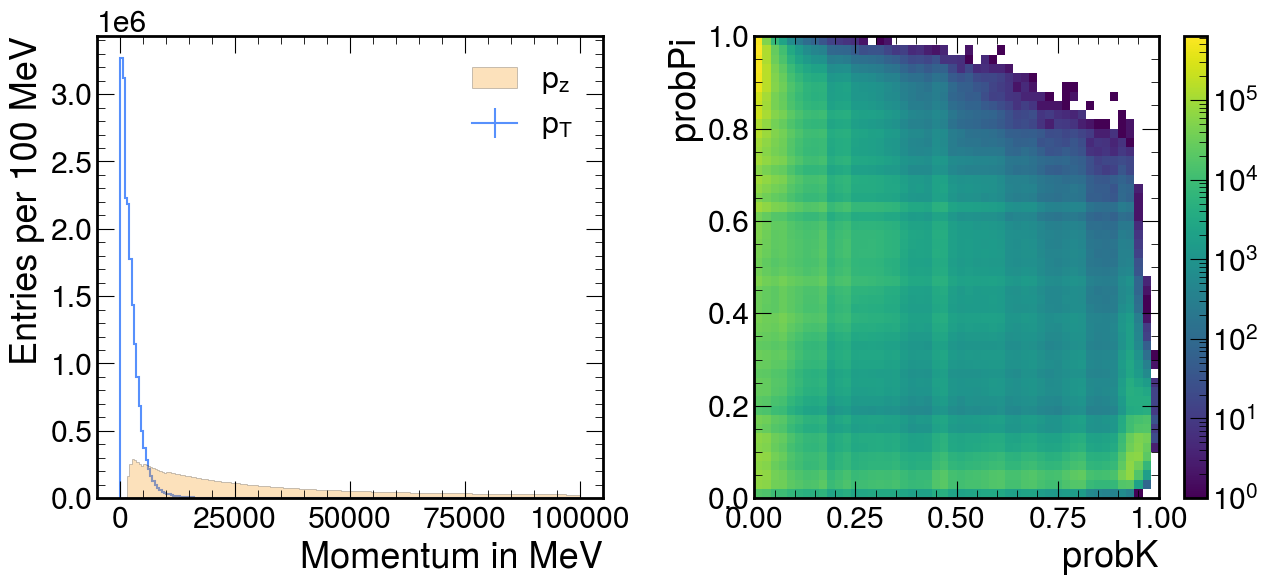

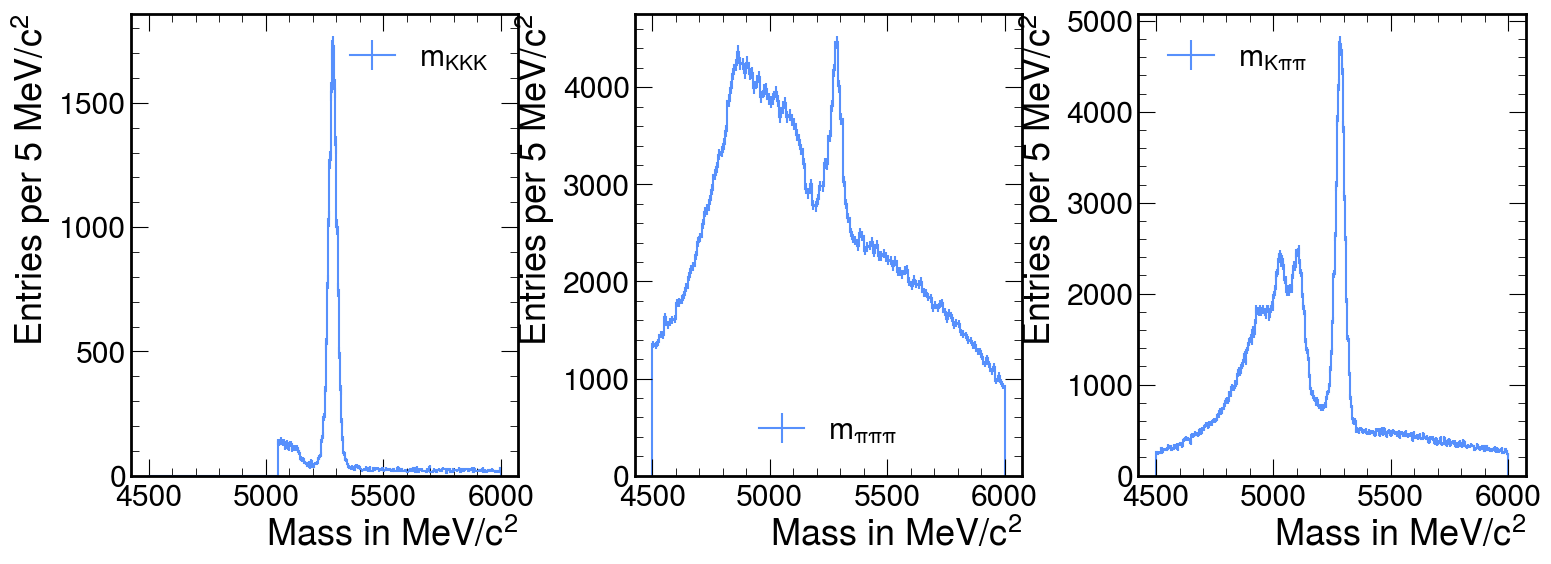

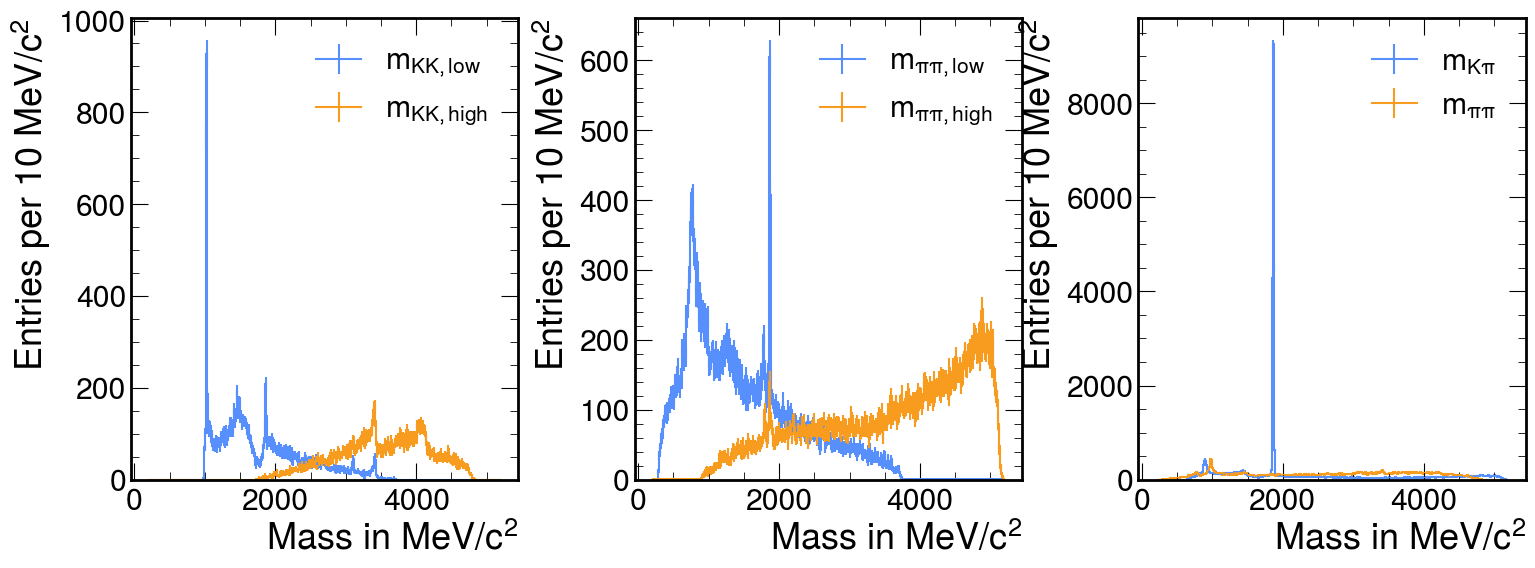

In [20]:
# Plot some histograms

h_pT = ROOT.TH1F("h_pT", "p_{T} Distribution", 200, 0, 100000)
for col in ["pT_H1", "pT_H2", "pT_H3"]:
    h_temp = df_basic.Histo1D((f"h_{col}", col, 200, 0, 100000), col).GetValue()
    h_pT.Add(h_temp)

h_pZ = ROOT.TH1F("h_pZ", "p_{z} Distribution", 200, 0, 100000)
for col in ["H1_PZ", "H2_PZ", "H3_PZ"]:
    h_temp = df_basic.Histo1D((f"h_{col}", col, 200, 0, 100000), col).GetValue()
    h_pZ.Add(h_temp)


h2d_prob = ROOT.TH2F("h2d_prob", "probK vs probPi;probK;probPi", 50, 0, 1, 50, 0, 1)
for h1, h2 in zip(["H1_ProbK", "H2_ProbK", "H3_ProbK"], ["H1_ProbPi", "H2_ProbPi", "H3_ProbPi"]):
    h_temp = df_basic.Histo2D((f"h2d_{h1}_{h2}", f"{h1} vs {h2}", 50, 0, 1, 50, 0, 1), h1, h2).GetValue()
    h2d_prob.Add(h_temp)

# First line of plots
# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
plt.style.use(hep.style.ROOT)
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig1.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
hep.histplot([h_pT], ax=ax1[0], histtype='step', label='$p_{T}$', linewidth=1.5)
hep.histplot([h_pZ], ax=ax1[0], histtype='fill', label='$p_{z}$', alpha=0.3, edgecolor='black', linewidth=0.5)
ax1[0].set_xlabel('Momentum in MeV')
ax1[0].set_ylabel('Entries per 100 MeV')
ax1[0].legend()
plt.savefig('../outputs/pTpZ.pdf')

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
# hep.hist2dplot(h2d_prob.values(), ax=ax[1], norm=colors.LogNorm())
x_bins = np.linspace(0, 1, 51)
y_bins = np.linspace(0, 1, 51)
z_data = np.array([[h2d_prob.GetBinContent(i, j) for j in range(1, 51)] 
                    for i in range(1, 51)])
im = ax1[1].pcolormesh(x_bins, y_bins, z_data.T, norm=colors.LogNorm(vmin=1), shading='auto')
plt.colorbar(im, ax=ax1[1])
ax1[1].set_xlabel('probK')
ax1[1].set_ylabel('probPi')
plt.savefig('../outputs/probKpi.pdf')


# Second line of plots
fig2, ax2 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig2.subplots_adjust(wspace=0.3) # increase horizontal space between plots
mass_configs = [
    (h_mKKK.GetValue(), kkk_selected_val, r'$m_{KKK}$', ax2[0], "KKK Mass Distribution"),
    (h_mpipipi.GetValue(), pipipi_selected_val, r'$m_{\pi\pi\pi}$', ax2[1], "πππ Mass Distribution"),
    (h_mKpipi.GetValue(), kpi_selected_val, r'$m_{K\pi\pi}$', ax2[2], "Kππ Mass Distribution")
]
for hist_value, count, label, ax, desc in mass_configs:
    hep.histplot(hist_value, ax=ax, histtype='step', label=label)

ax2[0].set_xlabel('Mass in MeV/$c^2$')
ax2[0].set_ylabel('Entries per 5 MeV/$c^2$')
ax2[0].legend()
plt.savefig('../outputs/mKKK.pdf')
ax2[1].set_xlabel('Mass in MeV/$c^2$')
ax2[1].set_ylabel('Entries per 5 MeV/$c^2$')
ax2[1].legend()
plt.savefig('../outputs/mpipipi.pdf')
ax2[2].set_xlabel('Mass in MeV/$c^2$')
ax2[2].set_ylabel('Entries per 5 MeV/$c^2$')
ax2[2].legend()
plt.savefig('../outputs/mKpipi.pdf')


# Third line of plots
fig3, ax3 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig3.subplots_adjust(wspace=0.3) # increase horizontal space between plots

pair_configs = [
    ([h_mKKlow.GetValue(), h_mKKhigh.GetValue()], kkk_mass_window_val, 
     [r'$m_{KK,low}$', r'$m_{KK,high}$'], ax3[0],
     ["KK Low Mass Distribution", "KK High Mass Distribution"]),
    
    ([h_mpipilow.GetValue(), h_mpipihigh.GetValue()], pipipi_mass_window_val, 
     [r'$m_{\pi\pi,low}$', r'$m_{\pi\pi,high}$'], ax3[1],
     ["ππ Low Mass Distribution", "ππ High Mass Distribution"]),
    
    ([h_mKpi.GetValue(), h_mpipi.GetValue()], kpi_mass_window_val, 
     [r'$m_{K\pi}$', r'$m_{\pi\pi}$'], ax3[2],
     ["Kπ Mass Distribution", "ππ Mass Distribution (in Kππ)"])
]

for h_list, count, labels, ax, descriptions in pair_configs:
    for i, (hist_value, label, desc) in enumerate(zip(h_list, labels, descriptions)):
        hep.histplot(hist_value, ax=ax, histtype='step', label=label, linewidth=1.5)

ax3[0].set_xlabel('Mass in MeV/$c^2$')
ax3[0].set_ylabel('Entries per 10 MeV/$c^2$')
ax3[0].legend()
plt.savefig('../outputs/mKK.pdf')
ax3[1].set_xlabel('Mass in MeV/$c^2$')
ax3[1].set_ylabel('Entries per 10 MeV/$c^2$')
ax3[1].legend()
plt.savefig('../outputs/mpipi.pdf')
ax3[2].set_xlabel('Mass in MeV/$c^2$')
ax3[2].set_ylabel('Entries per 10 MeV/$c^2$')
ax3[2].legend()
plt.savefig('../outputs/mKpi_pipi.pdf')

plt.show()

### Analyse data
The cell below fits a function to the histogram data for transverse momentum. While the different plotting style requires some manipulation of the data points, no new histogram is created from the input data but rather the histogram produced in the previous cell is used.

In [21]:
values_mpipipi = h_mpipipi.counts()

snb = values_mpipipi[78]
b = (values_mpipipi[69] + values_mpipipi[87]) / 2
s = snb - b
significance = s / np.sqrt(snb) if snb > 0 else 0

print('Kmax', probK_max, 'piAll', probpi_all, 'piSum', probpi_sum, 
      'S', s, 'B', b, 'S/B', s/b, 'sig', significance)

Kmax 0.7 piAll 0.6 piSum 2.4 S 1894.5 B 2569.5 S/B 0.7373029772329247 sig 28.355187057477085


!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!
!!! histogram déjà conforme au protocole !!!


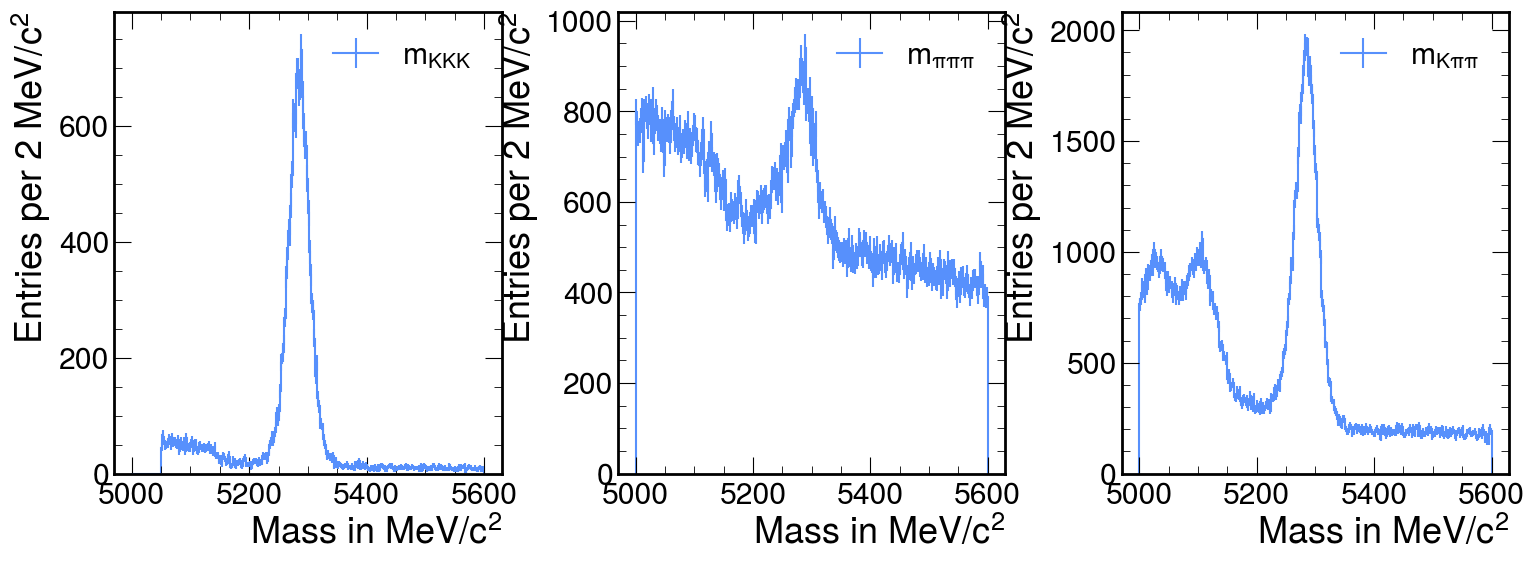

In [22]:
fig4, ax4 = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig4.subplots_adjust(wspace=0.3)

hep.histplot(h_mKKK_narrow.GetPtr(), ax=ax4[0], histtype='step', label=r'$m_{KKK}$', linewidth=1.5)
hep.histplot(h_mpipipi_narrow.GetPtr(), ax=ax4[1], histtype='step', label=r'$m_{\pi\pi\pi}$', linewidth=1.5)
hep.histplot(h_mKpipi_narrow.GetPtr(), ax=ax4[2], histtype='step', label=r'$m_{K\pi\pi}$', linewidth=1.5)

ax4[0].set_xlabel('Mass in MeV/$c^2$')
ax4[0].set_ylabel('Entries per 2 MeV/$c^2$')
ax4[0].legend()
plt.savefig('../outputs/mKKK_narrow.pdf')
ax4[1].set_xlabel('Mass in MeV/$c^2$')
ax4[1].set_ylabel('Entries per 2 MeV/$c^2$')
ax4[1].legend()
plt.savefig('../outputs/mpipipi_narrow.pdf')
ax4[2].set_xlabel('Mass in MeV/$c^2$')
ax4[2].set_ylabel('Entries per 2 MeV/$c^2$')
ax4[2].legend()
plt.savefig('../outputs/mKpipi_narrow.pdf')

Fit results with chi2/ndf 310.37500446721015 / 188
Par 1: 2404.201387 +/- 798.258034
Par 2: 23.490863 +/- 7.494589
Par 3: 28962.300303 +/- 191.857797
Par 4: 5284.995241 +/- 0.110558
Par 5: 17.403566 +/- 0.118004
Par 6: 35.737690 +/- 7.081628
Par 7: 388.907301 +/- 96.135945
Fit results with chi2/ndf 282.6476054509443 / 200
Par 1: 7902.156195 +/- 1430.599238
Par 2: 28.800148 +/- 4.039612
Par 3: 18679.082140 +/- 657.002658
Par 4: 5282.067621 +/- 0.670740
Par 5: 22.742922 +/- 0.756708
Par 6: 677.880696 +/- 13.765794
Par 7: 1171.540944 +/- 75.471384
Fit results with chi2/ndf 374.7147260076972 / 200
Par 1: 43600.887243 +/- 1432.925145
Par 2: 27.829660 +/- 0.695860
Par 3: 76177.989709 +/- 546.601304
Par 4: 5284.661589 +/- 0.125179
Par 5: 18.803726 +/- 0.135347
Par 6: 471.786214 +/- 17.566581
Par 7: 477.659792 +/- 25.730815


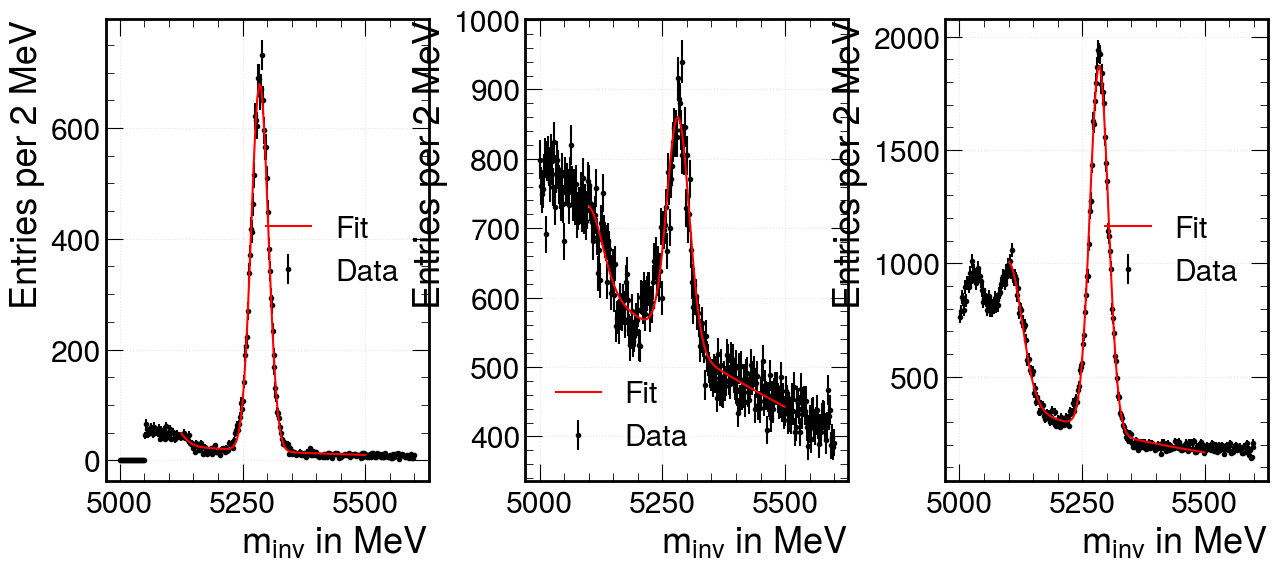

In [23]:
from scipy.optimize import curve_fit

# decaying exponential function
def exponential(x, norm, decay):
    return np.array( norm * np.exp(-(x-5000)/decay) )

# constant function
def constant(x, norm):
    return np.array( norm )

# Gaussian function
def gauss(x, norm, mu, sigma):
    return np.array( norm / np.sqrt(2*np.pi) / sigma * np.exp( -(x-mu)**2 / 2 / sigma**2 ) )

# fit function combining two individual functions
def fit_function(x, norm4, sigma4, normG, muG, sigmaG, normE, decay):
    return np.array( gauss(x, norm4, 5100, sigma4) + gauss(x, normG, muG, sigmaG) + exponential(x, normE, decay) )

def fit_data(hist_ptr, minX, maxX, p0):
    n_bins = hist_ptr.GetNbinsX()
    bin_centres = []
    values = []
    
    # Extract bin centers and values from the histogram
    for i in range(1, n_bins + 1):
        bin_center = hist_ptr.GetBinCenter(i)
        bin_content = hist_ptr.GetBinContent(i)
        bin_centres.append(bin_center)
        values.append(bin_content)
    
    # Reduce range to fit only part of curve
    bin_centres_red = []
    values_red = []
    for c, v in zip(bin_centres, values):
        if c < minX or c > maxX:
            continue
        bin_centres_red.append(c)
        values_red.append(v)
    
    # Execute the fit
    coeff_fit, cov_fit = curve_fit(fit_function, bin_centres_red, values_red, p0)
    fit_vals = [fit_function(x, coeff_fit[0], coeff_fit[1], coeff_fit[2], 
                            coeff_fit[3], coeff_fit[4], coeff_fit[5], coeff_fit[6]) 
                for x in bin_centres_red]
    
    # Calculate chi2
    chi2parts = np.array((np.divide(np.array(values_red) - np.array(fit_vals), 
                        np.sqrt(values_red), 
                        out=np.zeros_like(values_red), 
                        where=np.array(values_red) != 0))**2)  # Add small epsilon to avoid division by zero
    chi2 = np.sum(chi2parts)
    
    return coeff_fit, cov_fit, bin_centres, bin_centres_red, chi2, len(chi2parts)

def print_results(coeff,cov,chi2,ndf):
    perr = np.sqrt(np.diag(cov)) # extract errors from covarianve matrix
    # output fit results
    print('Fit results with chi2/ndf', chi2,'/',ndf)
    parcount = 0
    for p,e in zip(coeff,perr):
        parcount += 1
        print('Par {:d}: {:f} +/- {:f}'.format(parcount,p,e))

def plot_results(ax, bin_centres, bin_centres_red, values, coeff_fit, fname):
    # Plot the data with error bars
    ax.errorbar(bin_centres, values, yerr=np.sqrt(np.array(values) + 1e-10), 
               linestyle='', marker='.', markerfacecolor='k', markeredgecolor='k', 
               ecolor='k', label='Data')
    
    # Plot the fit if successful
    if coeff_fit is not None and len(bin_centres_red) > 0:
        x_fit = np.linspace(bin_centres_red[0], bin_centres_red[-1], 100)
        y_fit = fit_function(x_fit, coeff_fit[0], coeff_fit[1], coeff_fit[2], 
                           coeff_fit[3], coeff_fit[4], coeff_fit[5], coeff_fit[6])
        ax.plot(x_fit, y_fit, label='Fit', color='r', zorder=10)
    
    # Plot decoration
    ax.legend()# 
    ax.set_xlabel(r'$m_{inv}$ in MeV')
    ax.set_ylabel('Entries per 2 MeV')
    ax.grid(True, alpha=0.3)
    plt.savefig(f"{fname}")

fig5, ax5 = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
fig5.subplots_adjust(wspace=0.3)

coeff_KKK_fit, cov_KKK_fit, bin_centres_KKK, bin_centres_red_KKK, chi2_KKK, ndf_KKK = \
    fit_data(h_mKKK_narrow.GetPtr(), 5125, 5500, [2000, 30, 30000, 5285, 20, 40, 500])
print_results(coeff_KKK_fit, cov_KKK_fit, chi2_KKK, ndf_KKK)
kkk_hist = h_mKKK_narrow.GetPtr()
values_KKK = [kkk_hist.GetBinContent(i) for i in range(1, kkk_hist.GetNbinsX() + 1)]
plot_results(ax5[0], bin_centres_KKK, bin_centres_red_KKK, values_KKK, coeff_KKK_fit, '../outputs/mfit_KKK.pdf')

coeff_pipipi_fit, cov_pipipi_fit, bin_centres_pipipi, bin_centres_red_pipipi, chi2_pipipi, ndf_pipipi = \
    fit_data(h_mpipipi_narrow.GetPtr(), 5100, 5500, [8000, 30, 10000, 5285, 20, 1000, 500])
print_results(coeff_pipipi_fit, cov_pipipi_fit, chi2_pipipi, ndf_pipipi)
pipipi_hist = h_mpipipi_narrow.GetPtr()
values_pipipi = [pipipi_hist.GetBinContent(i) for i in range(1, pipipi_hist.GetNbinsX() + 1)]
plot_results(ax5[1], bin_centres_pipipi, bin_centres_red_pipipi, values_pipipi, coeff_pipipi_fit, '../outputs/mfit_pipipi.pdf')

coeff_Kpipi_fit, cov_Kpipi_fit, bin_centres_Kpipi, bin_centres_red_Kpipi, chi2_Kpipi, ndf_Kpipi = \
    fit_data(h_mKpipi_narrow.GetPtr(), 5100, 5500, [15000, 30, 60000, 5285, 20, 400, 500])
print_results(coeff_Kpipi_fit, cov_Kpipi_fit, chi2_Kpipi, ndf_Kpipi)
kpi_hist = h_mKpipi_narrow.GetPtr()
values_Kpipi = [kpi_hist.GetBinContent(i) for i in range(1, kpi_hist.GetNbinsX() + 1)]
plot_results(ax5[2], bin_centres_Kpipi, bin_centres_red_Kpipi, values_Kpipi, coeff_Kpipi_fit, '../outputs/mfit_Kpipi.pdf')

plt.show()

In [24]:
end_time = time.time()
elapsed = end_time - start_time
minutes = int(elapsed // 60)
seconds = int(elapsed % 60)
print(f"Total execution time: {minutes} min {seconds} sec")

Total execution time: 0 min 43 sec
